<a href="https://colab.research.google.com/github/realmistic/pysteps-basic-fin-analysis/blob/master/Part3_NLP_Sentiment_Analysis_for_Stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TO** READ "Stock News Sentiment Analysis with Python": https://towardsdatascience.com/stock-news-sentiment-analysis-with-python-193d4b4378d4
https://finviz.com/quote.ashx?t=DAL&ty=c&ta=1&p=d

Additional idea: use the specific set of articles from the website - that may be available over a longer period of time, rather than NewsAPI


**Article outline**

1) **Intro**: 'Why news and NLP?'
The stock market can be influenced by the news: it can be any important thing about the company (eg new contract, new business line, strong manager hired , etc.), or  financial results (quarterly and annual earnings, profits , etc.) compared with analysts expectations .
In this article you will try to get automatically the list of news using the newsapi API, apply sentiment analysis, and compare the results with the stock/index prices (we covered the data piece for this in the prev email)

2) **News Api**: show the endpoints for get everything/ sources. Show how to get list of ids for only business English sources. Show the python wrapper and the functionality that is limited compared to the newsapi API (the idea is that you can get it with the requests library using the full functionality).
   It is not ideal though: you don't understand if the news are relevant to the stocks, you have only 1 month of history. 
   Alternative to investigate: 
   - Finviz https://finviz.com/quote.ashx?t=DAL&ty=c&ta=1&p=d 
   - the article: https://towardsdatascience.com/stock-news-sentiment-analysis-with-python-193d4b4378d4
   You can have links of articles and their names that are highly relevant and hand-curated
  
3) **Sentiment analysis: introduce the library**
- https://medium.com/analytics-vidhya/simplifying-social-media-sentiment-analysis-using-vader-in-python-f9e6ec6fc52f
- the paper!!: http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf
  I like to cover not only compound, but also positive, neutral, and negative.
  We can also check what is more correlated with the graph movements.

  Show scores for several article names.

4)**The idea:** analyse one event with the news sentiment

Get one request for BRK.B (Berkshire Hathaway Inc.) stock around 9th July 
- check the links list, descriptions, and short contents. Are the news similar, are they relevant to financials?
We selected 9th July and large capitalisation stock brk.b because there are many news about it and there was a jump in stock’s price. We will try to find the evidence why did that happen In the news coverage.

 What does it show on the news about brk.b stock. Can it be debugged ? (Show which words Influenced on positive/negative sentiment)
Compare the sentiment score vs. Stock rise and speculate what articles may influenced its growth 

5) **Scale the analysis**: check daily news (about stocks) sentiment vs. growth of S&P500 index.

- 5.1) option 1 : all news from the en newspapers about stocks (we get max number =100 news via python library ). 
- 5.2) option 2: we limit the sources only to 7 business related sources (it is 20-30 news about Stocks).

We compare both results vs. Index movement and find that business news sentiment is visually more correlated with the move . 


In [ ]:
# GLOBAL PARAMS - for one event

SHOW_ALL_ARTICLES = True
# SHOW_ALL_ARTICLES = False

#the day of the event 
# STARTD = '22-Jun-2020' 
# STARTD = '19-Jun-2020' 
STARTD = '9-Jul-2020'


#the search phrase for News API
# KEYWRD = 'Inovio Pharmaceuticals stock'
# KEYWRD = 'Apple Inc.'
KEYWRD = 'Berkshire Hathaway Inc.'


#tiker
# tkr = "INO"
# tkr = 'AAPL'
tkr = 'BRK-B'
# tkr = 'LMND'


# 0) Imports

In [ ]:
import sys
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
### Uncomment it when the script runs for the first time 
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
!pip install newsapi-python

In [ ]:
!pip install yfinance

  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=99fe0752110545a9f8505d0db87772ab5066857ba7d8f648a055dea182390b49
  Stored in directory: /root/.cache/pip/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance


In [ ]:
from newsapi import NewsApiClient
#from newsapi.newsapi_client import NewsApiClient
from datetime import date, timedelta, datetime
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import yfinance as yf


In [ ]:
# Show full output in Colab
# https://stackoverflow.com/questions/54692405/output-truncation-in-google-colab
pd.set_option('display.max_colwidth',1000)

# 1) News API BY KEYWORD - download some news on a search keyword for a specific date, sorted on relevancy for language =en, first 100 articles

## 1.0) Define functions calling news api

We use this function to call one end point to filter proper sources

In [ ]:
# https://newsapi.org/docs/endpoints/sources
# https://github.com/mattlisiv/newsapi-python

def get_sources(category = None):
  newsapi = NewsApiClient(api_key='1900869fa01647fca0bdc19b4550daa0')
  sources = newsapi.get_sources()
  if category is not None:
    rez = [source['id'] for source in sources['sources'] if source['category'] == category and source['language'] == 'en']
  else:
    rez = [source['id'] for source in sources['sources'] if source['language'] == 'en']
  return rez


In [ ]:
# 81 en sources
len(get_sources())

81

In [ ]:
# 7 business sources
get_sources('business')

['australian-financial-review',
 'bloomberg',
 'business-insider',
 'business-insider-uk',
 'financial-post',
 'fortune',
 'the-wall-street-journal']

In [ ]:
type(date(2020,1,1))

datetime.date

In [ ]:
# https://github.com/mattlisiv/newsapi-python/blob/master/newsapi/newsapi_client.py
#  https://newsapi.org/docs/endpoints/everything


def get_articles_sentiments(keywrd, startd, sources_list = None, show_all_articles = False):
   
  newsapi = NewsApiClient(api_key='1900869fa01647fca0bdc19b4550daa0')
  if type(startd) == str:
    my_date = datetime.strptime(startd,'%d-%b-%Y')
  else:
    my_date = startd
  # business_en_sources = get_sources('business','en')
  if sources_list:
    articles = newsapi.get_everything(q=keywrd,
                                      from_param = my_date.isoformat(), 
                                      to = (my_date + timedelta(days = 1)).isoformat(),
                                      language="en",
                                      sources = ",".join(sources_list),
                                      sort_by="relevancy",
                                      page_size = 100)
  else:
     articles = newsapi.get_everything(q=keywrd,
                                      from_param = my_date.isoformat(), 
                                      to = (my_date + timedelta(days = 1)).isoformat(),
                                      language="en",
                                      sort_by="relevancy",
                                      page_size = 100)
  article_content = ''

  date_sentiments = {}
  date_sentiments_list = []
  seen = set()
  
  for article in articles['articles']:
    if str(article['title']) in seen:
      continue
    else:
      seen.add(str(article['title']))
      article_content = str(article['title']) + '. ' + str(article['description'])
      
      sentiment = sia.polarity_scores(article_content)['compound']
      date_sentiments.setdefault(my_date, []).append(sentiment)
      date_sentiments_list.append((sentiment, article['url'],article['title'],article['description']))
  date_sentiments_l = sorted(date_sentiments_list, key=lambda tup: tup[0],reverse=True)   
  sent_list = list(date_sentiments.values())[0]

  return pd.DataFrame(date_sentiments_list, columns=['Sentiment','URL','Title','Description'])

## 1.1) Test 2 versions for all news with q='stock': for ALL en sources

0.2392840000000001
100
0                                                                                                                                                         Deciding whether or not to sell your company stock (or when to sell it) is not a decision to enter into lightly.
1     Robinhood, the U.S.-based stock trading app, is postponing its U.K. launch “indefinitely,” more than a year and a half after the company begun executing on plans to cross the pond. It now intends to refocus its efforts on its home market. In November last yea…
2     Tesla’s six-month average trailing market capitalization hit $150 billion on Tuesday after a four-month run up of the automaker’s share price that theoretically unlocks a multibillion-dollar vesting option for CEO Elon Musk. Once Tesla hit the six-month avera…
3                                                                                                      European stock index futures rose on Tuesday after European Union leaders

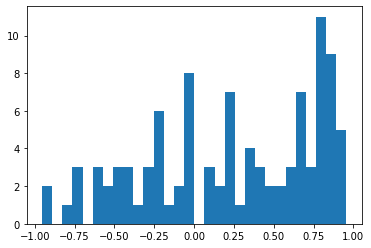

In [ ]:
# Easy version when we don't filter the business source -- seems to be relevant though, but the description
# Get all sources in en
return_articles = get_articles_sentiments(keywrd= 'stock' ,startd = '21-Jul-2020',sources_list = None, show_all_articles= True)
return_articles.Sentiment.hist(bins=30,grid=False)
print(return_articles.Sentiment.mean())
print(return_articles.Sentiment.count())
print(return_articles.Description)



Result: you can see 100 articles, with a lot of neutral sentiment,
and it is skewed towards very positive

In [ ]:
return_articles.sort_values(by='Sentiment', ascending=True)[['Sentiment','URL']].head(2)

,Sentiment,URL
79,-0.9545,https://www.reuters.com/article/us-wirecard-accounts-idUSKCN24N23V
82,-0.9081,https://in.reuters.com/article/us-wirecard-accounts-idINKCN24N23V


In [ ]:
return_articles.sort_values(by='Sentiment', ascending=True)[['Sentiment','URL']].tail(2)

,Sentiment,URL
78,0.9382,https://www.reuters.com/article/japan-stocks-midday-idUSL3N2ES06S
87,0.9559,https://www.marketwatch.com/story/best-buy-says-sales-are-better-during-pandemic-stock-heads-toward-all-time-high-2020-07-21


Top negative: https://www.reuters.com/article/india-nepal-palmoil-idUSL3N2ES1Y3
Nepal stops buying (New Dehli Suspended 39 oil import...)

In [ ]:
return_articles.sort_values(by='Sentiment', ascending=True)[['Sentiment','URL']].head(2)

,Sentiment,URL
79,-0.9545,https://www.reuters.com/article/us-wirecard-accounts-idUSKCN24N23V
82,-0.9081,https://in.reuters.com/article/us-wirecard-accounts-idINKCN24N23V


From the article above: "TOKYO, July 21 (Reuters) - Japanese stocks rose on Tuesday as signs of progress in developing a COVID-19 vaccine boosted investor confidence in the outlook for future economic growth."

## 1.2 Same as 1.1, but try only business sources : different articles covered?

0.13023582089552233
67
0         <ul>\n<li>Tesla CEO Elon Musk appears to have unlocked the second of his compensation goals on Tuesday. </li>\n<li>Despite a slight dip Tuesday, the company's average market cap has been above $150 billion for long enough to unlock the second tranche of stock a…
1         <ul>\n<li> In the last 24 hours, nearly 36,000 Robinhood traders have added shares of Pfizer, according to data from Robintrack.net. </li>\n<li>Pfizer and BioNTech announced Wednesday that the US government had placed an order for 100 million doses of its coron…
2        <ul>\n<li>There's a lot riding on Tesla's second-quarter earnings report Wednesday afternoon.</li>\n<li>Analysts expect the company to post a $75 million loss for the three-month period ended June 31.</li>\n<li>Despite factory shutdowns and falling deliveries, t…
3        <ul>\n<li>Tesla reports its highly anticipated second-quarter earnings on Wednesday after market close. </li>\n<li>The report comes after the automak

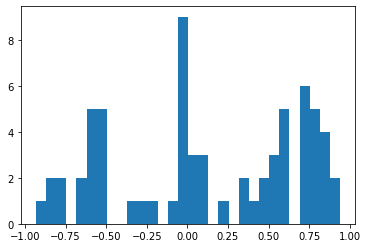

In [ ]:
# Look at only business sources in en
sources = get_sources('business')
return_articles = get_articles_sentiments('stock','21-Jul-2020',sources_list=sources, show_all_articles=True)
return_articles.Sentiment.hist(bins=30,grid=False)
print(return_articles.Sentiment.mean())
print(return_articles.Sentiment.count())
print(return_articles.Description)


0.18224745762711864
59


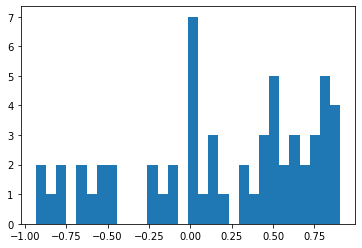

In [ ]:
return_articles = get_articles_sentiments('stock','20-Jul-2020', sources_list=sources, show_all_articles=True)
return_articles.Sentiment.hist(bins=30,grid=False)
print(return_articles.Sentiment.mean())
print(return_articles.Sentiment.count())


0.1451959595959596

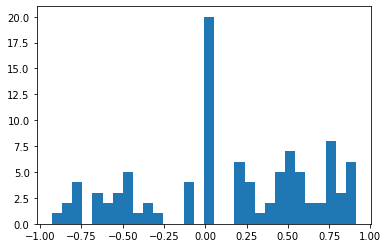

In [ ]:
return_articles = get_articles_sentiments('stock','19-Jul-2020',show_all_articles=True)
return_articles.Sentiment.hist(bins=30,grid=False)
return_articles.Sentiment.mean()


# 2) Get sentiment for 1 month:  q= 'stocks', 'en' language, with and without business category filter

In [ ]:
from datetime import date

end_date = date.today()
start_date = date(year=end_date.year, month=end_date.month-1, day=end_date.day) 

print('Start day = ', start_date)
print('End day = ', end_date)

current_day = start_date
business_sources = get_sources('business')
sentiment_all_score = []
sentiment_business_score = []
dates=[]


while current_day <= end_date:
  
  dates.append(current_day)

  sentiments_all = get_articles_sentiments(keywrd= 'stock' ,
                                          #  current_day.strftime('%b-%d-%Y'),
                                       startd = current_day,
                                       sources_list = None, 
                                       show_all_articles= True)
  sentiment_all_score.append(sentiments_all.mean())

  sentiments_business = get_articles_sentiments(keywrd= 'stock' ,
                                      #  startd = current_day.strftime('%b-%d-%Y'),
                                       startd = current_day,
                                       sources_list = business_sources, 
                                       show_all_articles= True)
  
  sentiment_business_score.append(sentiments_business.mean())

  current_day = current_day + timedelta(days=1)

Start day =  2020-06-29
End day =  2020-07-29


In [ ]:
sentiments = pd.DataFrame([dates,np.array(sentiment_all_score),np.array(sentiment_business_score)]).transpose()

In [ ]:
sentiments.columns=['Date','All_sources_sentiment','Business_sources_sentiment']

In [ ]:
sentiments['Date'] = pd.to_datetime(sentiments['Date'])

In [ ]:
sentiments['All_sources_sentiment'] = sentiments['All_sources_sentiment'].astype(float)
sentiments['Business_sources_sentiment'] = sentiments['Business_sources_sentiment'].astype(float)

In [ ]:
sentiments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        31 non-null     datetime64[ns]
 1   All_sources_sentiment       31 non-null     float64       
 2   Business_sources_sentiment  31 non-null     float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 872.0 bytes


In [ ]:
sentiments.set_index("Date", inplace=True)

In [ ]:
sentiments.head()

,All_sources_sentiment,Business_sources_sentiment
Date,,
2020-06-29,0.131628,0.102284
2020-06-30,0.247646,0.254857
2020-07-01,0.346280,0.201171
2020-07-02,0.273105,0.169240
2020-07-03,0.260752,0.207650


# 3) S&P 500 and Dow Jones index - reuse from the prev article

In [ ]:

# https://pydata.github.io/pandas-datareader/remote_data.html#stooq-index-data
# FRED: Federal Reserve Economic Data // fred,stlouisfed.org
import pandas_datareader.data as pdr
# from datetime import datetime
from datetime import date
end = date.today()
# start = datetime(2020,1,1)
start = datetime(year=end.year, month=end.month-1, day=end.day) 
# end = datetime(2020,6,29)
print(f'Period 1 year until today: {start} to {end} ')

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


NameError: ignored

In [ ]:
spx_index = pdr.get_data_stooq('^SPX', start, end) 
dji_index = pdr.get_data_stooq('^DJI',start,end)


NameError: ignored

In [ ]:
spx_index.index

In [ ]:
spx_index['Close'].plot(title='1 month price history for index S&P500 Index')

In [ ]:
dji_index['Close'].plot(title='1 month price history for index Dow Jones Index')

In [ ]:
sentiments_vs_snp = sentiments.join(spx_index['Close']).dropna()

# spx_index['Close'].join(sentiments).head()
  #  plot(title='1 month price history for index S&P500')

In [ ]:
sentiments_vs_snp.rename(columns={'Close':'s&p500_close'}, inplace=True)

In [ ]:
sentiments_vs_snp.head()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# https://stackoverflow.com/questions/31594549/how-do-i-change-the-figure-size-for-a-seaborn-plot
# https://stackoverflow.com/questions/47591650/second-y-axis-time-series-seaborn
sns.set(rc={'figure.figsize':(13.0,8.0)})


ax=sns.lineplot(data=sentiments_vs_snp['s&p500_close'], color="b",label='S&P500 Close price')
ax2 = plt.twinx()
sns.lineplot(data=sentiments_vs_snp["All_sources_sentiment"], color="g", ax=ax2, label='All sources sentiment')


In [ ]:
# BUSINESS SENTIMENT LOOKS CLOSER!

sns.set(rc={'figure.figsize':(13.0,8.0)})


ax=sns.lineplot(data=sentiments_vs_snp['s&p500_close'], color="b", label='S&P500 Close price')
ax2 = plt.twinx()
sns.lineplot(data=sentiments_vs_snp["Business_sources_sentiment"], color="g", ax=ax2, label='Business_sources_sentiment')

# 4.1) Individual cases - Shopify

In [ ]:
business_sources

NameError: ignored

In [ ]:
startd='29-Jul-2020'
shopify_stock = get_articles_sentiments("Shopify", startd, sources_list = business_sources, show_all_articles = True)

NameError: ignored

In [ ]:
shopify_stock

In [ ]:
shopify_stock_all = get_articles_sentiments("Shopify", startd, sources_list = None, show_all_articles = True)

In [ ]:
shopify_stock_all.Sentiment.mean()

In [ ]:
shopify_stock_all

In [ ]:
# Previous day
startd='28-Jul-2020'

shopify_stock_all_prevDay = get_articles_sentiments("Shopify", startd, sources_list = None, show_all_articles = True)

In [ ]:
shopify_stock_all_prevDay.Sentiment.mean()

In [ ]:
shopify_stock_all_prevDay

In [ ]:
from datetime import date

end_date = date.today()
start_date = date(year=end_date.year, month=end_date.month-1, day=end_date.day) 

print('Start day = ', start_date)
print('End day = ', end_date)

current_day = start_date
sentiment_all_score = []
dates=[]


while current_day <= end_date:
  
  dates.append(current_day)

  sentiments_all = get_articles_sentiments(keywrd= 'Shopify' ,
                                          #  current_day.strftime('%b-%d-%Y'),
                                       startd = current_day,
                                       sources_list = None, 
                                       show_all_articles= True)
  sentiment_all_score.append(sentiments_all.mean())

  current_day = current_day + timedelta(days=1)

In [ ]:
sentiments_shopify = pd.DataFrame([dates,np.array(sentiment_all_score)]).transpose()

In [ ]:
sentiments_shopify.columns

In [ ]:
# sentiments_shopify.columns=['Date','All_sources_sentiment']
# sentiments_shopify['Date'] = pd.to_datetime(sentiments_shopify['Date'])
# sentiments_shopify['All_sources_sentiment'] = sentiments_shopify['All_sources_sentiment'].astype(float)
sentiments_shopify.set_index("Date", inplace=True)

In [ ]:
sentiments_shopify.plot()

# 4.2) GAFA stock - 30 july earnings call :get news and sentiment for Google, Amazon, Facebook, Apple